# Voice gender recognition (DNN)

Below is the project of building voice gender recognition model(using DNN) and finding the best parameter regularization and the best accuracy.

Importing libraries

In [1]:
#!pip install dataprep

^C


In [8]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import l1, l2
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ReduceLROnPlateau
#from dataprep.eda import plot

import seaborn as sns

Loading the dataframe

In [7]:
#read input data using pandas
#can use ../ to indicate the file in the path that it exists in
data = pd.read_csv('../input/voicegender/voice.csv')

#display the data in csv
data

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3163,0.131884,0.084734,0.153707,0.049285,0.201144,0.151859,1.762129,6.630383,0.962934,0.763182,...,0.131884,0.182790,0.083770,0.262295,0.832899,0.007812,4.210938,4.203125,0.161929,female
3164,0.116221,0.089221,0.076758,0.042718,0.204911,0.162193,0.693730,2.503954,0.960716,0.709570,...,0.116221,0.188980,0.034409,0.275862,0.909856,0.039062,3.679688,3.640625,0.277897,female
3165,0.142056,0.095798,0.183731,0.033424,0.224360,0.190936,1.876502,6.604509,0.946854,0.654196,...,0.142056,0.209918,0.039506,0.275862,0.494271,0.007812,2.937500,2.929688,0.194759,female
3166,0.143659,0.090628,0.184976,0.043508,0.219943,0.176435,1.591065,5.388298,0.950436,0.675470,...,0.143659,0.172375,0.034483,0.250000,0.791360,0.007812,3.593750,3.585938,0.311002,female


We don't have a lot of objects in the dataset and I want to use a DNN. For reducing overfitting let's find the best regularization parameter and find the best accuracy then let's use DNN with Dropout. It is different techniques of regularization and interesting compare accuracies.

First of all, let's analyze the data using seaborn library

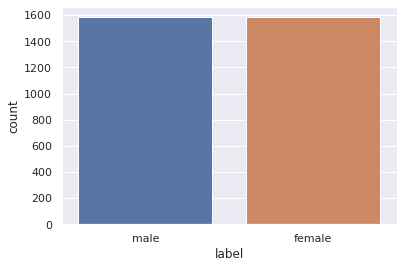

In [11]:
#plot the labeled data, there seems to be equal male and female data
sns.set_theme(style="darkgrid")
ax = sns.countplot(x = "label", data = data)

We have equal objects labeled as female and male 

Splitting the data into train and test

In [12]:
#y = labels, putting the labels into a numpy array
y = data['label'].copy()
y = np.array(y)

In [13]:
#replacing all male labels with 0 and female labels with 1
y = np.where(y == 'male', 0, y)
y = np.where(y == 'female', 1, y)
y = np.asarray(y).astype(np.float32)

In [14]:
#features without the labels column
x = data.drop('label', axis=1).copy()

#puts all the data into a numpy array
x = np.array(x, dtype='float32')

In [15]:
#split into test and training
(trainX, testX, trainY, testY) = train_test_split(x,
    y, test_size=0.25, random_state=42)

In [16]:
#array of regularizer values to be tested later to find the best parameter for reducing overfit
regul = [0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005, 0.00001]

#for experimentation + documentation, list that holds the accuracy for each experiment
all_train, all_test = list(), list()
models = list()

#training hyperparameters
#learning rate
INIT_LR = 0.0002
EPOCHS = 150
BATCH = 8

## Finding best regularization parameter for reducing overfitting

Let's build models with different regularization parameters.

In [17]:
#for loop, builds a model for each of the regularizer parameters
for param in regul:
    # define model
    model = Sequential()
    model.add(tf.keras.layers.Dense(input_shape=(trainX.shape[1],), units=256, 
                                activation="relu", kernel_regularizer=l2(param)))
    model.add(tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=l2(param)))
    model.add(tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=l2(param)))
    model.add(tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=l2(param)))
    model.add(tf.keras.layers.Dense(32, activation="relu", kernel_regularizer=l2(param)))
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
    #compile the model using Adam as an optimizer and 
    
    #a binary cross entropy as a loss function
    print("[INFO] training network...")
    opt = Adam(lr=INIT_LR)
    model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
    
    #callbacks = operations to perform during learning to improve performance, control learning
    #reduceLRonPlateau = reduce learning rate by 1/2 if loss does not improve after 5 epochs. do not let lr go under 0.00001
    callbacks = [ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=0.00001)] 
    
    #fit function, history created
    #stores the metrics that are created when the model runs during training
    history_model = model.fit(trainX, trainY, epochs=EPOCHS, batch_size=BATCH, callbacks=callbacks, verbose=1)
    
    #add history to the array
    models.append(model)
    
    # evaluate the model using train and test data, loss and accuract
    #_ means you don't care about the first output, only keep the second output from the function
    _, train_acc = model.evaluate(trainX, trainY, verbose=0)
    _, test_acc = model.evaluate(testX, testY, verbose=0)
    print('Param: %f, Train: %.3f, Test: %.3f' % (param, train_acc, test_acc))
    all_train.append(train_acc)
    all_test.append(test_acc)

[INFO] training network...
Epoch 1/150
297/297 [==============================] - 1s 2ms/step - loss: 4.1438 - accuracy: 0.5024
Epoch 2/150
297/297 [==============================] - 0s 2ms/step - loss: 2.6051 - accuracy: 0.5474
Epoch 3/150
297/297 [==============================] - 0s 2ms/step - loss: 2.0031 - accuracy: 0.6145
Epoch 4/150
297/297 [==============================] - 1s 2ms/step - loss: 1.7291 - accuracy: 0.6182
Epoch 5/150
297/297 [==============================] - 0s 2ms/step - loss: 1.5579 - accuracy: 0.6641
Epoch 6/150
297/297 [==============================] - 0s 2ms/step - loss: 1.4524 - accuracy: 0.6567
Epoch 7/150
297/297 [==============================] - 0s 2ms/step - loss: 1.3583 - accuracy: 0.6645
Epoch 8/150
297/297 [==============================] - 0s 2ms/step - loss: 1.2749 - accuracy: 0.6749
Epoch 9/150
297/297 [==============================] - 0s 2ms/step - loss: 1.2022 - accuracy: 0.6751
Epoch 10/150
297/297 [==============================] - 0s 2ms/s

Plotting train and test accuracies depending on regularization parameters

In [ ]:
plt.semilogx(regul, all_train, label='train', marker='o')
plt.semilogx(regul, all_test, label='test', marker='o')
plt.legend()
plt.show()

Building dataframe for finding high accuracy and low difference between train and test accuracies. It will define the best regularization parameter

In [ ]:
all_train_array = np.array(all_train)
all_test_array = np.array(all_test)
accuracy_frame = pd.DataFrame({
                        'regularization' : regul,
                        'accuracy_on_train': all_train_array*100, 
                         'accuracy_on_test': all_test_array*100,
                         'accuracy_difference': abs((all_train_array - all_test_array)*100)
                              })
acc=accuracy_frame.sort_values(by=['accuracy_difference'])
acc

The best accuracy is 97% and best parameter regularization is 0.005

In [ ]:
#best model was models[1], 2nd model
#testing the 2nd model on the test data
predict = (models[1].predict(testX) > 0.5).astype("int32")

#functions that give the metrics about the testing accuracy, recall, f1 score, etc.
print(classification_report(testY,predict))
print(confusion_matrix(testY, predict))

In [ ]:
print('Accuracy:',(accuracy_score(testY, predict))*100)

## DNN with Dropout

Let's build model with Dropout regularization technique for reducing overfitting

Setting the model

In [ ]:
all_train, all_test = list(), list()
models = list()
parameters = c
for i in parameters:
    model = Sequential()
    model.add(Dense(input_shape=(trainX.shape[1],), units=256, 
                                activation="relu"))
    model.add(Dropout(i))
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(i))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(32, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    #compile the model using Adam as an optimizer and 
    #a binary cross entropy as a loss function
    print("[INFO] training network...")
    opt = Adam(lr=INIT_LR)
    model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
    callbacks = [ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=0.00001)] 
    history_model = model.fit(trainX, trainY, epochs=EPOCHS, batch_size=BATCH, callbacks=callbacks, verbose=1)
    models.append(model)
    # evaluate the model using train and test data
    _, train_acc = model.evaluate(trainX, trainY, verbose=0)
    _, test_acc = model.evaluate(testX, testY, verbose=0)
    print('Param: %f, Train: %.3f, Test: %.3f' % (param, train_acc, test_acc))
    all_train.append(train_acc)
    all_test.append(test_acc)

Plotting train and test accuracies depending on Dropout parameter

In [ ]:
plt.semilogx(parameters, all_train, label='train', marker='o')
plt.semilogx(parameters, all_test, label='test', marker='o')
plt.legend()
plt.show()

In [ ]:
all_train_array = np.array(all_train)
all_test_array = np.array(all_test)
accuracy_frame = pd.DataFrame({
                        'parameter' : parameters,
                        'accuracy_on_train': all_train_array*100, 
                         'accuracy_on_test': all_test_array*100,
                         'accuracy_difference': abs((all_train_array - all_test_array)*100)
                              })
acc=accuracy_frame.sort_values(by=['accuracy_difference'])
acc

In [ ]:
predict = (models[3].predict(testX) > 0.5).astype("int32")
print(classification_report(testY,predict))
print(confusion_matrix(testY, predict))

In [ ]:
print('Accuracy:',(accuracy_score(testY, predict))*100)